<a href="https://colab.research.google.com/github/swimbeginner/TensorFlow2/blob/main/LogisticRegression_12252020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#From google tensorFlow Crash course 
[classification model](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/binary_classification.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=binary_classification_tf2-colab&hl=en#scrollTo=TL5y5fY9Jy_x)


In [3]:
%tensorflow_version 2.x

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows=10
pd.options.display.float_format="{:.1f}".format
print("run the import statement")

run the import statement


In [5]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

## Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should 
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2

In [6]:
train_df_mean=train_df.mean()
train_df_std=train_df.std()
train_df_norm=(train_df-train_df_mean)/train_df_std
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1672,1.2,-1.2,-1.1,0.2,0.0,0.1,0.1,0.7,-0.3
11108,-0.7,1.0,-0.1,-0.2,-0.1,-0.4,-0.1,-0.7,-0.8
12903,-1.1,0.8,-0.1,0.2,0.2,1.6,0.3,0.4,-0.3
10791,-0.6,-0.1,-1.0,-1.1,-1.2,-0.8,-1.2,-1.2,-1.4
16133,-1.4,1.0,1.6,-0.4,-0.5,-0.3,-0.5,-0.5,0.2


In [7]:
test_df_mean=test_df.mean()
test_df_std=test_df.std()
test_df_norm=(test_df-test_df_mean)/test_df_std
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1


In [23]:
threshold = 265000 # This is the 75th percentile for median house values.
train_df_norm["median_house_value_is_high"] = [1.0 if i>=threshold else 0 for i in train_df["median_house_value"]]
test_df_norm["median_house_value_is_high"] = [1.0 if i>=threshold else 0 for i in test_df["median_house_value"]]

# Print out a few example cells from the beginning and 
# middle of the training set, just to make sure that
# your code created only 0s and 1s in the newly created
# median_house_value_is_high column
train_df_norm["median_house_value_is_high"].head(8000)

1672    0.0
11108   0.0
12903   0.0
10791   0.0
16133   0.0
         ..
7374    1.0
13317   1.0
5392    0.0
11217   0.0
7663    1.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [24]:
#answers from the course
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)

1672    0.0
11108   0.0
12903   0.0
10791   0.0
16133   0.0
         ..
7374    1.0
13317   1.0
5392    0.0
11217   0.0
7663    1.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

##Represent the features in  feature columns

In [25]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.749059  ,  0.17676374],
       [-0.7173301 , -0.16774005],
       [ 0.39290377,  0.22171895],
       ...,
       [-1.2382517 , -1.0567524 ],
       [-0.04841222,  3.6557472 ],
       [-0.9239693 , -0.5209596 ]], dtype=float32)>

In [28]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [29]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 1ms/step - loss: 0.7361 - accuracy: 0.2732
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6390 - accuracy: 0.2809
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5657 - accuracy: 0.3951
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5109 - accuracy: 0.6784
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7554
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4425 - accuracy: 0.7820
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.8001
Epoch 8/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4151 - accuracy: 0.8064
Epoch 9/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4029 - accurac

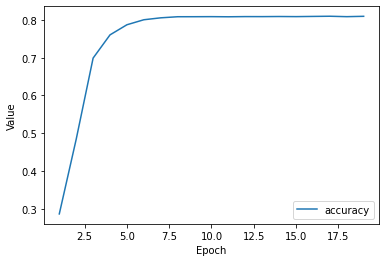

In [30]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

##Accuracy is the only metrics

In [31]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8003


[0.40685421228408813, 0.8003333210945129]

##Add precision and recall as metrics

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 1ms/step - loss: 0.6945 - accuracy: 0.4507 - precision: 0.2834 - recall: 0.8045
Epoch 2/50
170/170 [==============================] - 0s 1ms/step - loss: 0.6145 - accuracy: 0.5613 - precision: 0.3417 - recall: 0.7796
Epoch 3/50
170/170 [==============================] - 0s 1ms/step - loss: 0.5402 - accuracy: 0.6587 - precision: 0.3997 - recall: 0.7413
Epoch 4/50
170/170 [==============================] - 0s 1ms/step - loss: 0.4929 - accuracy: 0.7187 - precision: 0.4600 - recall: 0.7170
Epoch 5/50
170/170 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.7523 - precision: 0.5032 - recall: 0.6807
Epoch 6/50
170/170 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7768 - precision: 0.5539 - recall: 0.6547
Epoch 7/50
170/170 [==============================] - 0s 2ms/step - 

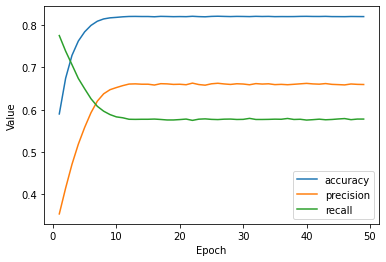

In [37]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 50
batch_size = 100
classification_threshold = 0.4
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 )
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.8095 - auc: 0.2620
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7009 - auc: 0.3309
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6133 - auc: 0.6058
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5455 - auc: 0.8015
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4990 - auc: 0.8370
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4574 - auc: 0.8386
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4417 - auc: 0.8332
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4235 - auc: 0.8368
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4156 - auc: 0.8348
Epoch 10/20
170/170 [==============

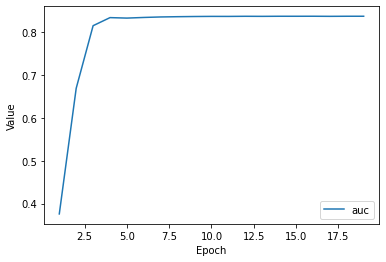

In [38]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [39]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 0.4068 - auc: 0.8261


[0.40681660175323486, 0.8260818719863892]